In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("../datasets/compas.csv")
df = df[df["DisplayText"] == "Risk of Recidivism"]
df.reset_index(inplace=True)
df

,index,PersonID,AssessmentID,CaseID,Agency,LastName,FirstName,MiddleName,Sex,Ethnicity,...,RecSupervisionLevel,RecSupervisionLevelText,ScaleID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
1,4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0
2,7,50855,57181,51963,PRETRIAL,DAYES,DANIEL,NaN,Male,African-American,...,4,High,8,Risk of Recidivism,0.18,8,High,New,1,0
3,10,50850,57176,51958,PRETRIAL,Debe,Mikerlie,George,Female,African-American,...,2,Medium,8,Risk of Recidivism,-0.53,6,Medium,New,1,0
4,13,50839,57162,51945,PRETRIAL,McLaurin,Stephanie,Nicole,Female,African-American,...,1,Low,8,Risk of Recidivism,-1.55,2,Low,New,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20276,60829,68595,79656,72031,PRETRIAL,PENA,ROLANDO,N,Male,Hispanic,...,2,Medium,8,Risk of Recidivism,-0.42,5,Medium,New,1,0
20277,60832,19968,39866,36500,PRETRIAL,BUTTERFIELD,JAMES,MICHAEL,Male,Caucasian,...,1,Low,8,Risk of Recidivism,-0.36,5,Medium,New,1,0
20278,60835,68598,79660,72035,PRETRIAL,SUAREZ,ANDERSON,NaN,Male,Caucasian,...,1,Low,8,Risk of Recidivism,-1.57,1,Low,New,1,0
20279,60838,65667,79665,72038,Probation,West,James,NaN,Male,African-American,...,3,Medium with Override Consideration,8,Risk of Recidivism,0.16,8,High,New,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20281 entries, 0 to 20280
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    20281 non-null  int64  
 1   PersonID                 20281 non-null  int64  
 2   AssessmentID             20281 non-null  int64  
 3   CaseID                   20281 non-null  int64  
 4   Agency                   20281 non-null  object 
 5   LastName                 20281 non-null  object 
 6   FirstName                20281 non-null  object 
 7   MiddleName               5216 non-null   object 
 8   Sex                      20281 non-null  object 
 9   Ethnicity                20281 non-null  object 
 10  DateOfBirth              20281 non-null  object 
 11  ScaleSetID               20281 non-null  int64  
 12  ScaleSet                 20281 non-null  object 
 13  AssessmentReason         20281 non-null  object 
 14  Language              

In [4]:
from fairlens.sensitive.detection import detect_names_df

sensitive_attributes = detect_names_df(df, deep_search=True)
sensitive_attributes

{'Sex': 'Gender',
 'Ethnicity': 'Ethnicity',
 'DateOfBirth': 'Age',
 'Language': 'Nationality',
 'MaritalStatus': 'Family Status'}

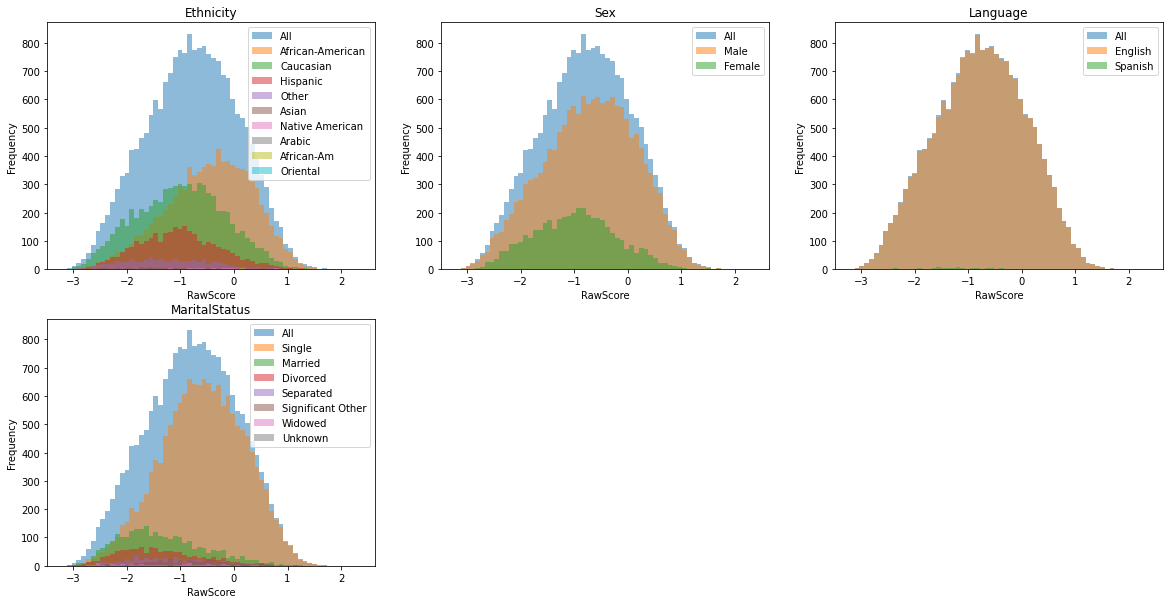

In [5]:
from fairlens.bias.viz import plt_attr_dist_mult

target_attribute = "RawScore"

plt_attr_dist_mult(df, target_attribute, ["Ethnicity", "Sex", "Language", "MaritalStatus"])
plt.show()

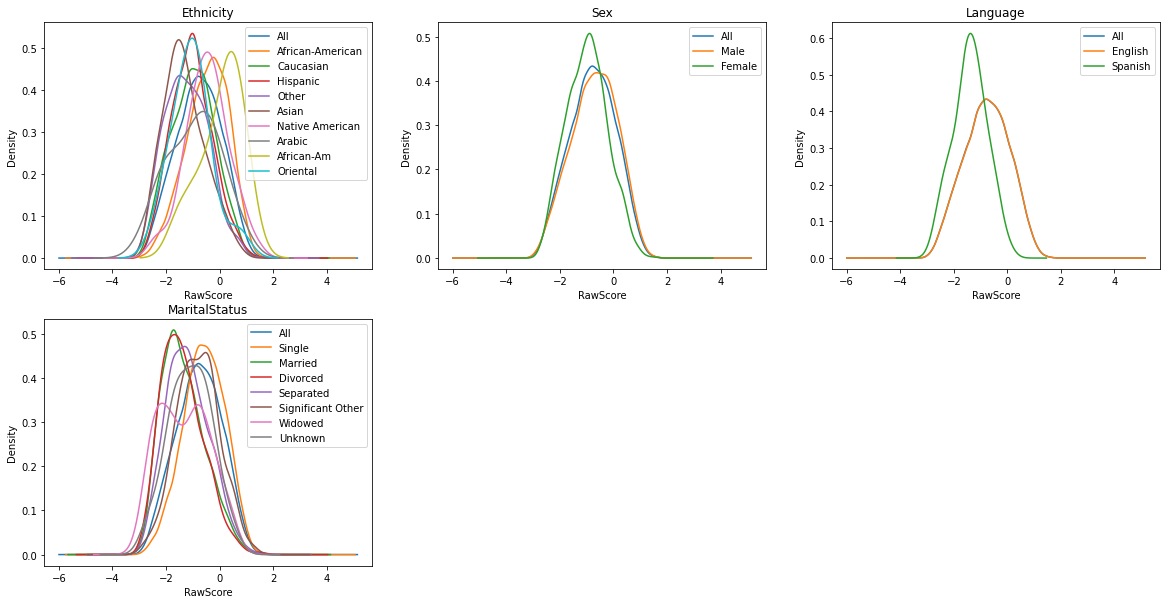

In [6]:
plt_attr_dist_mult(df, target_attribute, ["Ethnicity", "Sex", "Language", "MaritalStatus"], normalize=True, show_hist=False, show_curve=True)
plt.show()

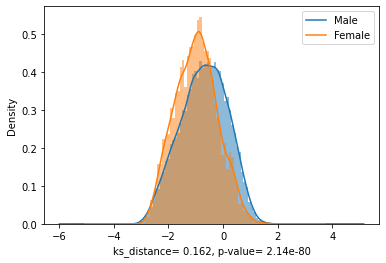

In [7]:
from fairlens.bias.viz import plt_group_dist

plt_group_dist(df, "RawScore", {"Sex": ["Male"]}, {"Sex": ["Female"]}, show_metric=True)

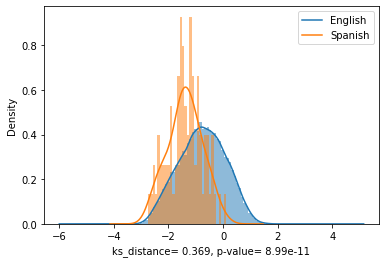

In [8]:
from fairlens.bias.viz import plt_group_dist

plt_group_dist(df, "RawScore", {"Language": ["English"]}, {"Language": ["Spanish"]}, show_metric=True)

In [9]:
from fairlens.bias.metrics import stat_distance
from fairlens.bias.distance import DistanceMetric

group1 = {"Sex": ["Male"]}
group2 = {"Sex": ["Female"]}
group3 = {"Language": ["English"]}
group4 = {"Language": ["Spanish"]}

target_attribute = "RawScore"

stat_distance(df, target_attribute, group1, group2, mode="auto", p_value=True)

(0.16236435605304522, 2.1425738350996494e-80)

In [10]:
distances = {}
for metric in ["mean", "emd", "ks_distance", "norm", "hellinger"]:
    try:
        dist, pval = stat_distance(df, target_attribute, group1, group2, mode=metric, p_value=True)
        distances[metric] = dist
    except Exception:
        print(metric, "failed")

pd.DataFrame.from_dict(distances, orient="index", columns=["distance"])

,distance
mean,0.272133
emd,0.274965
ks_distance,0.162364
norm,0.057039
hellinger,0.148697


In [11]:
distances = {}
for metric in ["mean", "emd", "ks_distance", "norm", "hellinger"]:
    try:
        dist, pval = stat_distance(df, target_attribute, group3, group4, mode=metric, p_value=True)
        distances[metric] = dist
    except Exception:
        print(metric, "failed")

pd.DataFrame.from_dict(distances, orient="index", columns=["distance"])

,distance
mean,0.622582
emd,0.617492
ks_distance,0.369090
norm,0.142478
hellinger,0.415647
